This script calculates the percentage of orders that reposition to an adjacent zone

## Load packges

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [4]:
trip_df = pd.read_csv('../data/trip_cleaned.csv')
adjacent_zone = pd.read_csv('../data/adjacent_zone.csv')
same_zones = pd.read_csv('../data/taxi_zone_lookup.csv')

## Get next pick-up zone

In [8]:
cols = ['hack_license', 'pickup_taxizone_id', 'dropoff_taxizone_id', 'first_pickup', 'last_dropoff']
trip_df_zones = trip_df[cols]
trip_df_zones.loc[:,'pickup_taxizone_id_next'] = trip_df_zones.groupby(['hack_license'])['pickup_taxizone_id'].shift(-1)
trip_df_zones = trip_df_zones.loc[trip_df_zones['last_dropoff'] == 0]
trip_df_zones.dropna(subset=['pickup_taxizone_id_next'], inplace=True) ## last trip of a driver in the raw df
trip_df_zones.reset_index(inplace=True, drop=True)
trip_df_zones.head()

,hack_license,pickup_datetime,pickup_taxizone_id,dropoff_taxizone_id,first_pickup,last_dropoff,pickup_taxizone_id_next
0,2013000001,2013-06-24 18:55:00,148.0,79.0,0.0,0,164.0
1,2013000001,2013-06-24 19:12:00,164.0,143.0,0.0,0,142.0
2,2013000001,2013-06-24 19:45:00,142.0,79.0,0.0,0,234.0
3,2013000001,2013-06-24 20:17:00,234.0,141.0,0.0,0,141.0
4,2013000001,2013-06-24 20:30:00,141.0,263.0,0.0,0,263.0


## Generate adjacent zone lookup table

In [6]:
# get adjacent zone lookup table
adj_zones = pd.concat([adjacent_zone,
                       adjacent_zone.rename(columns={'zone1':'zone2', 'zone2':'zone1'})], sort=True)
adj_zones.reset_index(inplace=True, drop=True)
# get same zone lookup table
same_zones = pd.DataFrame(np.tile(same_zones['LocationID'].unique(),(2,1)).T).rename(columns={0:'zone1', 1:'zone2'})

## Check if next pick-up zone adjacent

In [9]:
mask_adj= ~(trip_df_zones[['dropoff_taxizone_id',
                           'pickup_taxizone_id_next']].merge(adjacent_zone, how='left', 
                                                             left_on=['dropoff_taxizone_id','pickup_taxizone_id_next'],
                                                             right_on=['zone1','zone2']).zone1.isna())
mask_same= ~(trip_df_zones[['dropoff_taxizone_id',
                            'pickup_taxizone_id_next']].merge(same_zones, how='left', 
                                                              left_on=['dropoff_taxizone_id','pickup_taxizone_id_next'],
                                                              right_on=['zone1','zone2']).zone1.isna())
# 0: not adjacent zone
# 1: adjacent zone
# 2: same  zone
trip_df_zones.loc[:,'adj'] = 0
trip_df_zones.loc[mask_adj, 'adj'] = 1
trip_df_zones.loc[mask_same, 'adj'] = 2

## Repositioning TO non-adjacent/adjacent/same zone

In [96]:
reposition_dropoff = trip_df_zones.groupby(['dropoff_taxizone_id','adj']).agg({'adj':'count'}).rename(columns={'adj':'count'})
reposition_dropoff['percent'] = reposition_dropoff / reposition_dropoff.groupby(level=0).sum() * 100
reposition_dropoff.reset_index(inplace=True)
reposition_dropoff.columns = ['taxizone_id', 'adj', 'count','percent']

### By percentage

In [97]:
reposition_per_dropoff = reposition_dropoff.pivot_table(index='taxizone_id', 
                                                        columns='adj', values='percent').fillna(0).reset_index()
reposition_per_dropoff.columns = ['taxizone_id', 'non_adjacent', 'adjcent','same']
reposition_per_dropoff.head()

,taxizone_id,non_adjacent,adjcent,same
0,1.0,99.850848,0.000000,0.149152
1,2.0,42.857143,0.000000,57.142857
2,3.0,96.798493,1.129944,2.071563
3,4.0,30.714875,39.272373,30.012752
4,5.0,100.000000,0.000000,0.000000


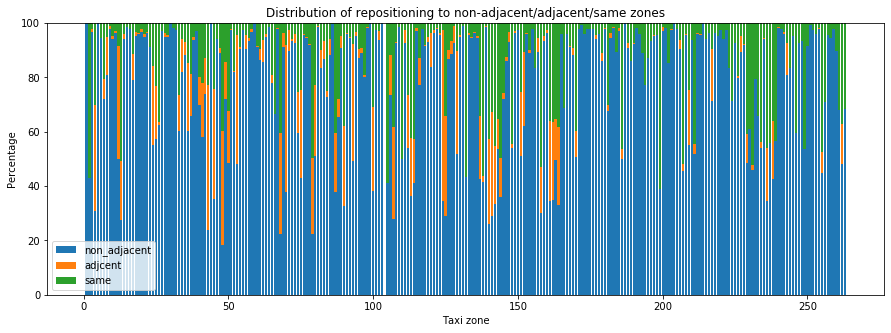

In [98]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
p1 = ax.bar(reposition_per_dropoff['taxizone_id'], reposition_per_dropoff['non_adjacent'], label='non_adjacent')
p2 = ax.bar(reposition_per_dropoff['taxizone_id'], reposition_per_dropoff['adjcent'], 
             bottom=reposition_per_dropoff['non_adjacent'], label='adjcent')
p3 = ax.bar(reposition_per_dropoff['taxizone_id'], reposition_per_dropoff['same'], 
            bottom=reposition_per_dropoff['non_adjacent']+reposition_per_dropoff['adjcent'], 
            label='same')
ax.legend();
ax.set_xlabel('Taxi zone');
ax.set_ylabel('Percentage');
ax.set_title('Distribution of repositioning to non-adjacent/adjacent/same zones');

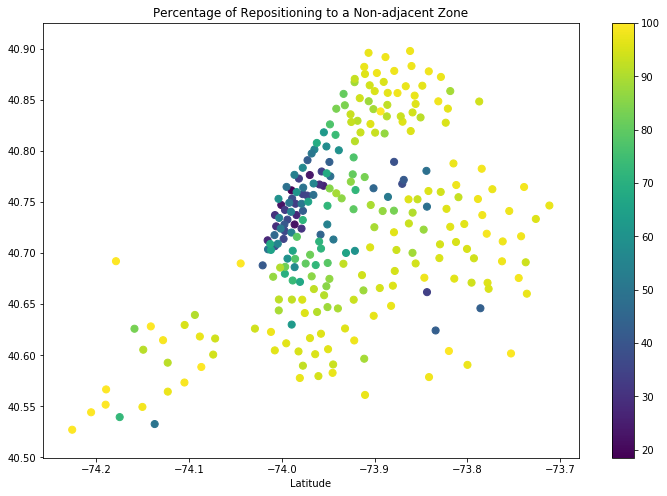

In [140]:
geo_loc_df = trip_df.groupby('dropoff_taxizone_id', 
                             as_index=False)[['dropoff_latitude', 'dropoff_longitude']].agg('mean').reset_index(drop=True)
geo_loc_df = reposition_per_dropoff.merge(geo_loc_df,left_on='taxizone_id',right_on='dropoff_taxizone_id')
fig, ax = plt.subplots(1,1, figsize=(12,8))
p = ax.scatter(geo_loc_df['dropoff_longitude'],
           geo_loc_df['dropoff_latitude'], s=50, c=geo_loc_df['non_adjacent'])
ax.set_xlabel('Longitude');
ax.set_xlabel('Latitude');
ax.set_title('Percentage of Repositioning to a Non-adjacent Zone');
plt.colorbar(p);

### By counts

In [99]:
reposition_count_dropoff = reposition_dropoff.pivot_table(index='taxizone_id', 
                                                          columns='adj', values='count').fillna(0).reset_index()
reposition_count_dropoff.columns = ['taxizone_id', 'non_adjacent', 'adjcent','same']
reposition_count_dropoff.head()

,taxizone_id,non_adjacent,adjcent,same
0,1.0,16067.0,0.0,24.0
1,2.0,6.0,0.0,8.0
2,3.0,514.0,6.0,11.0
3,4.0,20473.0,26177.0,20005.0
4,5.0,31.0,0.0,0.0


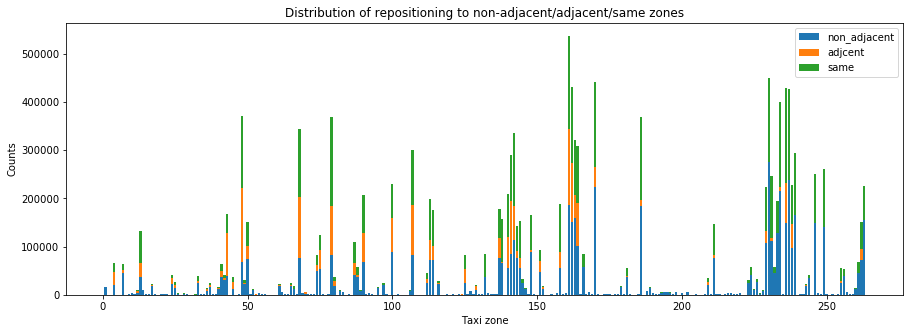

In [105]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
p1 = ax.bar(reposition_count_dropoff['taxizone_id'], reposition_count_dropoff['non_adjacent'], label='non_adjacent')
p2 = ax.bar(reposition_count_dropoff['taxizone_id'], reposition_count_dropoff['adjcent'], 
             bottom=reposition_count_dropoff['non_adjacent'], label='adjcent')
p3 = ax.bar(reposition_count_dropoff['taxizone_id'], reposition_count_dropoff['same'], 
            bottom=reposition_count_dropoff['non_adjacent']+reposition_count_dropoff['adjcent'], 
            label='same')
ax.legend();
ax.set_xlabel('Taxi zone');
ax.set_ylabel('Counts');
ax.set_title('Distribution of repositioning to non-adjacent/adjacent/same zones');

## Repositioning FROM non-adjacent/adjacent/same zone

In [91]:
reposition_pickup = trip_df_zones.groupby(['pickup_taxizone_id_next','adj']).agg({'adj':'count'}).rename(columns={'adj':'count'})
reposition_pickup['percent'] = reposition_pickup / reposition_pickup.groupby(level=0).sum() * 100
reposition_pickup.reset_index(inplace=True)
reposition_pickup.columns = ['taxizone_id', 'adj', 'count','percent']

### By percentage

In [92]:
reposition_per_pickup = reposition_pickup.pivot_table(index='taxizone_id',
                                                      
                                                          columns='adj', values='percent').fillna(0).reset_index()
reposition_per_pickup.columns = ['taxizone_id', 'non_adjacent', 'adjcent','same']
reposition_per_pickup.head()

,taxizone_id,non_adjacent,adjcent,same
0,1.0,62.500000,0.0,37.500000
1,2.0,11.111111,0.0,88.888889
2,3.0,35.294118,0.0,64.705882
3,4.0,58.400050,0.0,41.599950
4,6.0,27.777778,0.0,72.222222


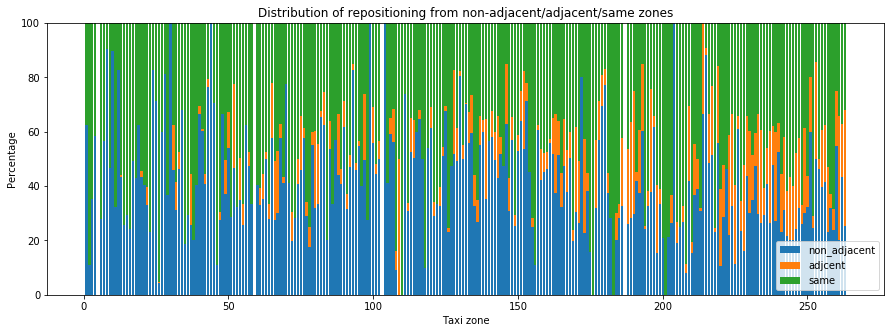

In [93]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
p1 = ax.bar(reposition_per_pickup['taxizone_id'], reposition_per_pickup['non_adjacent'], label='non_adjacent')
p2 = ax.bar(reposition_per_pickup['taxizone_id'], reposition_per_pickup['adjcent'], 
             bottom=reposition_per_pickup['non_adjacent'], label='adjcent')
p3 = ax.bar(reposition_per_pickup['taxizone_id'], reposition_per_pickup['same'], 
            bottom=reposition_per_pickup['non_adjacent']+reposition_per_pickup['adjcent'], 
            label='same')
ax.legend();
ax.set_xlabel('Taxi zone');
ax.set_ylabel('Percentage');
ax.set_title('Distribution of repositioning from non-adjacent/adjacent/same zones');

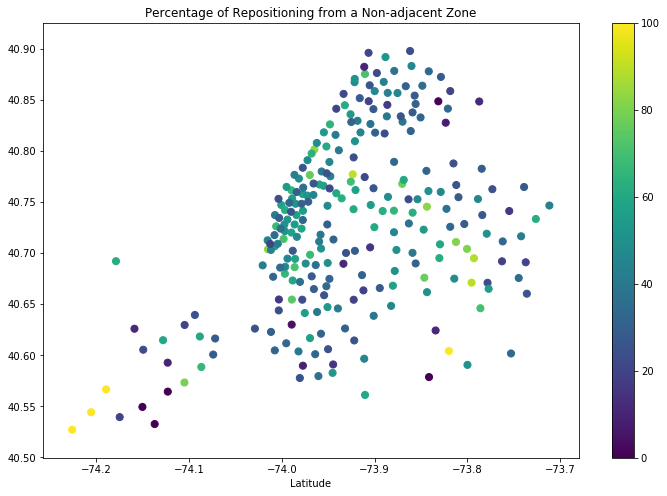

In [144]:
geo_loc_df = trip_df.groupby('dropoff_taxizone_id', 
                             as_index=False)[['dropoff_latitude', 'dropoff_longitude']].agg('mean').reset_index(drop=True)
geo_loc_df = reposition_per_pickup.merge(geo_loc_df,left_on='taxizone_id',right_on='dropoff_taxizone_id')
fig, ax = plt.subplots(1,1, figsize=(12,8))
p = ax.scatter(geo_loc_df['dropoff_longitude'],
           geo_loc_df['dropoff_latitude'], s=50, c=geo_loc_df['non_adjacent'])
ax.set_xlabel('Longitude');
ax.set_xlabel('Latitude');
ax.set_title('Percentage of Repositioning from a Non-adjacent Zone');
plt.colorbar(p);

### By counts

In [102]:
reposition_count_pickup = reposition_pickup.pivot_table(index='taxizone_id', 
                                                        columns='adj', values='count').fillna(0).reset_index()
reposition_count_pickup.columns = ['taxizone_id', 'non_adjacent', 'adjcent','same']
reposition_count_pickup.head()

,taxizone_id,non_adjacent,adjcent,same
0,1.0,40.0,0.0,24.0
1,2.0,1.0,0.0,8.0
2,3.0,6.0,0.0,11.0
3,4.0,28084.0,0.0,20005.0
4,6.0,5.0,0.0,13.0


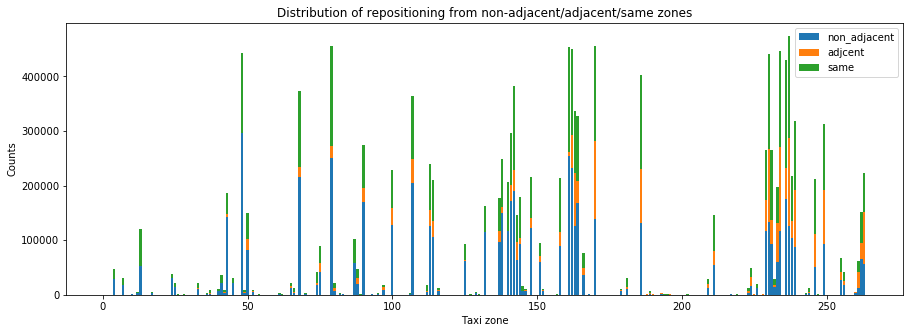

In [104]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
p1 = ax.bar(reposition_count_pickup['taxizone_id'], reposition_count_pickup['non_adjacent'], label='non_adjacent')
p2 = ax.bar(reposition_count_pickup['taxizone_id'], reposition_count_pickup['adjcent'], 
             bottom=reposition_count_pickup['non_adjacent'], label='adjcent')
p3 = ax.bar(reposition_count_pickup['taxizone_id'], reposition_count_pickup['same'], 
            bottom=reposition_count_pickup['non_adjacent']+reposition_count_pickup['adjcent'], 
            label='same')
ax.legend();
ax.set_xlabel('Taxi zone');
ax.set_ylabel('Counts');
ax.set_title('Distribution of repositioning from non-adjacent/adjacent/same zones');